In [1]:
from Annotation_helper import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

Sets correct values for generated figures:

In [2]:
#Set all settings for the resulting figures

import seaborn as sns
sns.set()

SMALL_SIZE = 15
MEDIUM_SIZE = 17
BIGGER_SIZE = 19

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

# Helper functions

In [3]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def avg_dict_values(d):
    res = dict()
    for key in d:
        res[key] = np.mean(d[key])
    return res

def append_dict(d1, d2):
    res = dict()
    if d1 == {}:
        for key in d2:
            res[key] = [d2[key]]
        return d2
    else:
        for key in d1:
            if type(d1[key]) != list:
                res[key] = [d1[key]] + [d2[key]]
            else:
                res[key] = d1[key] + [d2[key]]
        return res

def evaluate_rule_based_methods(model, kf, X, y, thresh):
    all_scores = dict()
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        pred = model.predict(X_test.to_numpy(), thresh)
        scores = evaluate_prediction(pred, y_test.to_numpy(), model_name = "Exact Match", figure_folder=figure_folder)
        all_scores = append_dict(all_scores, scores)
    return all_scores

def evaluate_stat_based_methods(model, kf, X, y):
    all_scores = dict()
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        mask = (X_train["SlaafNaamNieuw"] > 0.6)
        X_train = X_train[mask]
        y_train = y_train[mask]
        
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        scores = evaluate_prediction(pred, y_test, model_name = "Exact Match", figure_folder=figure_folder)
        all_scores = append_dict(all_scores, scores)
    return all_scores

In [4]:
# scoring = ['precision', 'recall', 'f1']
scoring = ['accuracy']

# Loading data
Set paths to files:

In [5]:
data_folder = "../../Data"
structured_data_folder = data_folder + "/structured_data"
text_path = data_folder + "/text"
data_path = structured_data_folder + "/test.csv"
dist_folder = structured_data_folder + "/Distances"
figure_folder = "../Figures/Results/Embeddings"
model_folder = "../Models/Embeddings"
matches = pd.read_csv(structured_data_folder + "/Matches/Bas.csv", index_col=0)
figure_folder = "../Figures/Results/Classic/"
error_folder = structured_data_folder + "/Errors/"

Load transaction and permission datasets:

In [6]:
transactions = load_transactions(structured_data_folder + "\VOC Cochin Slave Transactions 1706-1801 - IISH - Database - 2018 - v1.csv")
permissions = load_permissions(structured_data_folder + "\VOC Cochin Slave Transport Permissions 1770-1795 - IISH - Database - 2018 - v1.csv")

E:\UvA\Scriptie\Thesis_code\Annotation\Annotation_helper.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  col = col.str.replace('[^a-zA-Z ]', '')


Load distances between datasets from multiple files and merge them into one dataframe:

In [7]:
distances = pd.read_csv(dist_folder + "/distances_0.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
for i in range(1, 99):
    df2 = pd.read_csv(f"{dist_folder}/distances_{i}.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
    distances = pd.concat([distances, df2])
distances.reset_index(inplace=True)

Split the data into a test and training set:

In [8]:
all_data = distances[distances['permission_indx'].isin(matches["permission_indx"].unique())]
all_data["Match"] = 0
for i, match in matches.iterrows():
    if match["transaction_indx"] != "None":
        indx = distances.query(f"permission_indx == {match['permission_indx']} & transaction_indx == {match['transaction_indx']}").index
        all_data.loc[indx, "Match"] = 1
data = all_data.iloc[:, :-1]
y = all_data.iloc[:, -1]

<ipython-input-8-f1a6ee68ef38>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data["Match"] = 0
C:\Users\basvd\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [9]:
Classifiers = dict()
Scores = dict()

# Blocking
Perform blocking to reduce the size of the data

In [10]:
print(f"{data.shape[0]} rows before blocking")
mask = (data["SlaafNaamNieuw"] > 0.6)
X = data[mask]
y = y[mask]
print(f"{X.shape[0]} rows after blocking")

4981284 rows before blocking
79964 rows after blocking


In [11]:
X_df = X
X = X.iloc[:, 3:]

In [12]:
# X = X.iloc[:,3:].to_numpy().astype(float)
# y = y.to_numpy().astype(float)

In [13]:
# X = data

In [14]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Rule based

In [15]:
class Rule_based_classifier():
    def __init__(self, alg):
        self.alg = alg
        
    def predict_proba(self, X_test):
        pred = self.alg(X_test)
        return pred
    
    def predict(self, X_test, thresh):
        pred = self.alg(X_test)
        return (pred >= thresh).astype(float)

## Exact Match

In [16]:
def exact_match(X_test):
    pred = []
    for x in X_test:
        pred.append((x == 1.).sum())
    return np.array(pred)/X_test.shape[1]

In [17]:
Classifiers["Exact Match"] = Rule_based_classifier(exact_match)
s = evaluate_rule_based_methods(Classifiers["Exact Match"], kf, X, y, 0.6)
Scores["Exact Match"] = avg_dict_values(s)

## Fuzzy Match

In [18]:
def fuzzy_match(X_test):
    pred = []
    for x in X_test:
        pred.append((x > 0.8).sum())
    return np.array(pred)/X_test.shape[1]

In [19]:
Classifiers["Fuzzy Match"] = Rule_based_classifier(fuzzy_match)
s = evaluate_rule_based_methods(Classifiers["Fuzzy Match"], kf, X, y, 0.6)
Scores["Fuzzy Match"] = avg_dict_values(s)

# Statisitcal methods

# K nearest neighbors

In [20]:
model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=2))
s = evaluate_stat_based_methods(model, kf, X, y)
Scores["KNeigb ors classifier"] = avg_dict_values(s)

## Logistic Regression

In [21]:
model = make_pipeline(StandardScaler(), LogisticRegressionCV(scoring='f1', penalty='l2', max_iter=200))
s = evaluate_stat_based_methods(model, kf, X, y)
Scores["Logistic Regression"] = avg_dict_values(s)

## ADAboost

In [22]:
model = make_pipeline(StandardScaler(),AdaBoostClassifier(n_estimators=30, random_state=0))
s = evaluate_stat_based_methods(model, kf, X, y)
Scores["ADAboost"] = avg_dict_values(s)

## Naive Bayes

In [23]:
model = make_pipeline(Normalizer(), MultinomialNB())
s = evaluate_stat_based_methods(model, kf, X, y)
Scores["Naive Bayes"] = avg_dict_values(s)

C:\Users\basvd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\basvd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\basvd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\basvd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision 

## Linear Support Vector Classifier

In [24]:
model = make_pipeline(StandardScaler(), LinearSVC(random_state=0, max_iter=2000))
s = evaluate_stat_based_methods(model, kf, X, y)
Scores["Linear SVC"] = avg_dict_values(s)

C:\Users\basvd\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\basvd\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\basvd\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\basvd\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\basvd\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Neural Network

In [25]:
model = make_pipeline(StandardScaler(), MLPClassifier(activation='relu', solver='adam', alpha=1e-5, hidden_layer_sizes=(100, 100), learning_rate='adaptive', random_state=1, verbose=False))
s = evaluate_stat_based_methods(model, kf, X, y)
Scores["Neural network"] = avg_dict_values(s)

# Results table

In [26]:
s = []
for c in Scores:
    s.append(pd.Series(Scores[c]))
results = pd.concat(s, axis=1)
results.columns = Scores.keys()
results.transpose()

,recall score:,precision score:,f1 score:
Exact Match,0.099174,0.866667,0.173939
Fuzzy Match,0.319202,0.842857,0.458042
KNeigb ors classifier,0.825043,0.977500,0.892178
Logistic Regression,0.824872,0.857283,0.839853
ADAboost,0.844872,0.889455,0.863994
Naive Bayes,0.000000,0.000000,0.000000
Linear SVC,0.844872,0.862367,0.852078
Neural network,0.857208,0.917778,0.880948


In [27]:
model = make_pipeline(StandardScaler(), LogisticRegressionCV(scoring='f1', penalty='l2', max_iter=200))

model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(max_iter=200, scoring='f1'))])

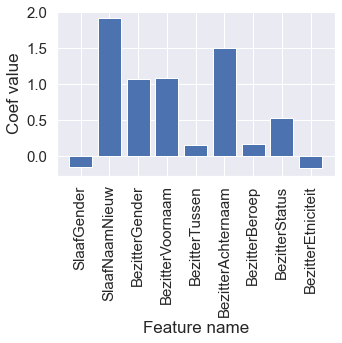

In [28]:
x = [i for i in range(0,len(X.columns))]
plt.rcParams["figure.figsize"] = (5,5)
plt.bar(X.columns, model[1].coef_[0])
plt.xticks(rotation = 90)
plt.xlabel("Feature name")
plt.ylabel("Coef value")
plt.tight_layout()
plt.savefig(figure_folder + "Coefs.png")

# Error Analysis

In [29]:
def evaluate_stat_based_methods(model, kf, X, y):
    all_scores = dict()
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        scores = evaluate_prediction(pred, y_test, model_name = "Exact Match", figure_folder=figure_folder)
        all_scores = append_dict(all_scores, scores)
    return all_scores

In [34]:
def add_prefix_to_columns(df, prefix):
    # Adds a given prefix to all column names
    cols = df.columns
    df.columns = [prefix + c for c in cols]
    return df

def get_mistakes(y_pred, y_true, X_df, t, p):
    # Filters out errors in predictions and saves them as csv files
    p.set_index("Entry-ID")
    mist_indx = np.invert(y_true == y_pred)
    mist_dist = X_df[mist_indx]
#     print(mist_dist.shape)
    mist_p = p.loc[mist_dist['permission_indx'], :]
    mist_t = t.loc[mist_dist['transaction_indx'], :]
    vt = add_prefix_to_columns(mist_t, "transaction_")
    vp = add_prefix_to_columns(mist_p, 'permission_')
    vals = np.concatenate((vt, vp), axis=1)
    mist_data = pd.DataFrame(data=vals, columns=list(vt) + list(vp), index=X_df.index[mist_indx])
#     print(mist_data.shape)
#     print(y_test.shape)
#     print(y_test[mist_data.index])
    mist_data["Match"] = y_test
    return mist_data

In [31]:
model = make_pipeline(StandardScaler(), LogisticRegressionCV(scoring='f1', penalty='l2', max_iter=200))

In [35]:
mistakes = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_test_df = X_df.iloc[test_index]
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mistakes.append(get_mistakes(pred, y_test, X_test_df, transactions, permissions))

In [36]:
X_test["Match"] = y_test
mist_data = pd.concat(mistakes)
mist_data[mist_data["Match"] == 0].to_csv(error_folder + "False_Positives.csv")
mist_data[mist_data["Match"] == 1].to_csv(error_folder + "False_Negatives.csv")

<ipython-input-36-03c874438cae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["Match"] = y_test
